In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
from matplotlib import transforms

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

# Read the Combined Pseudobulk Data

In [ ]:
combined = sc.read_h5ad("data/pseudobulk_combined.h5ad")
combined.shape

(360, 36601)

In [ ]:
# Rename some Samples
combined.obs["final_cell_annotation"] = combined.obs[
    "final_cell_annotation"
].str.replace("96_Skin Normal_Melanocyte", "Skin Normal_Melanocyte")
combined.obs["final_cell_annotation"] = combined.obs[
    "final_cell_annotation"
].str.replace(
    "21_Thyroid Normal_thyroid follicular cell",
    "Thyroid Normal_thyroid follicular cell",
)
combined.obs["final_cell_annotation"] = combined.obs[
    "final_cell_annotation"
].str.replace("11_Colon Normal_TA", "Colon Normal_TA")

In [ ]:
# Check the result
cell_types = combined.obs.final_cell_annotation.unique()

for i in range(len(cell_types)):
    print(cell_types[i])

Skin Normal_Melanocyte
MEL
THCA
Thyroid Normal_thyroid follicular cell
Kidney Normal_kidney loop of Henle thin ascending limb epithelial cell
RCC
HCC
Hepatocytes
Cholangiocytes
CHOL
Colon Normal_TA
CRC
HNSC
Head and Neck Normal_respiratory basal cell
Pancreas Normal_Trunk
PAAD
Fallopian Tube Normal_secretory cell
OV
TNBC
LummHR-major (Breast)
Lumsec-basal (Breast)
HER2+
ER+
UVM


In [ ]:
sc.pp.log1p(combined)  # log1p-transformation
print(combined.X.sum(axis=1))

In [ ]:
sc.pp.pca(combined, n_comps=5)  # PCA
sc.pp.neighbors(combined)  # Compute neighbors graph
sc.tl.umap(combined)  # UMAP

In [ ]:
with open("data/TFs.txt", "r") as f:
    tfs = [line.strip() for line in f]

print(len(tfs))

1639


In [ ]:
# Select only genes encoding TFs
adata_pseudobulk_with_tfs = combined[:, combined.var_names.isin(tfs)].copy()
adata_pseudobulk_with_tfs

AnnData object with n_obs × n_vars = 360 × 1627
    obs: 'Sample', 'final_cell_annotation', 'dataset', 'cnv_status', 'source'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Find the most active TFs

In [ ]:
# Devide pseudobulk into Normal and Cancer
normal_pseudobulk = adata_pseudobulk_with_tfs[
    adata_pseudobulk_with_tfs.obs["final_cell_annotation"].isin(
        [
            "Skin Normal_Melanocyte",
            "Kidney Normal_kidney loop of Henle thin ascending limb epithelial cell",
            "Hepatocytes",
            "Cholangiocytes",
            "Colon Normal_TA",
            "Head and Neck Normal_respiratory basal cell",
            "Pancreas Normal_Trunk",
            "Fallopian Tube Normal_secretory cell",
            "LummHR-major (Breast)",
            "Lumsec-basal (Breast)",
        ]
    )
]
cancer_pseudobulk = adata_pseudobulk_with_tfs[
    adata_pseudobulk_with_tfs.obs["final_cell_annotation"].isin(
        [
            "MEL",
            "THCA",
            "RCC",
            "HCC",
            "CHOL",
            "CRC",
            "HNSC",
            "PAAD",
            "OV",
            "TNBC",
            "HER2+",
            "ER+",
            "UVM",
        ]
    )
]

In [ ]:
# Find the most active TFs in Normal
sc.tl.rank_genes_groups(
    normal_pseudobulk, groupby="final_cell_annotation", method="wilcoxon", n_genes=5
)
all_markers = []
for ct in normal_pseudobulk.obs["final_cell_annotation"].cat.categories:
    markers = (
        sc.get.rank_genes_groups_df(normal_pseudobulk, group=ct)
        .head(5)["names"]
        .tolist()
    )
    all_markers.extend(markers)

/home/karitskaya/miniconda3/envs/my_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [15]:
len(all_markers)

50

In [16]:
len(adata_pseudobulk_with_tfs.var_names)

1627

In [17]:
desired_order = normal_pseudobulk.obs.final_cell_annotation.unique()
desired_order

['Skin Normal_Melanocyte', 'Kidney Normal_kidney loop of Henle thin ascen..., 'Hepatocytes', 'Cholangiocytes', 'Colon Normal_TA', 'Head and Neck Normal_respiratory basal cell', 'Pancreas Normal_Trunk', 'Fallopian Tube Normal_secretory cell', 'LummHR-major (Breast)', 'Lumsec-basal (Breast)']
Categories (10, object): ['Cholangiocytes', 'Colon Normal_TA', 'Fallopian Tube Normal_secretory cell', 'Head and Neck Normal_respiratory basal cell', ..., 'LummHR-major (Breast)', 'Lumsec-basal (Breast)', 'Pancreas Normal_Trunk', 'Skin Normal_Melanocyte']

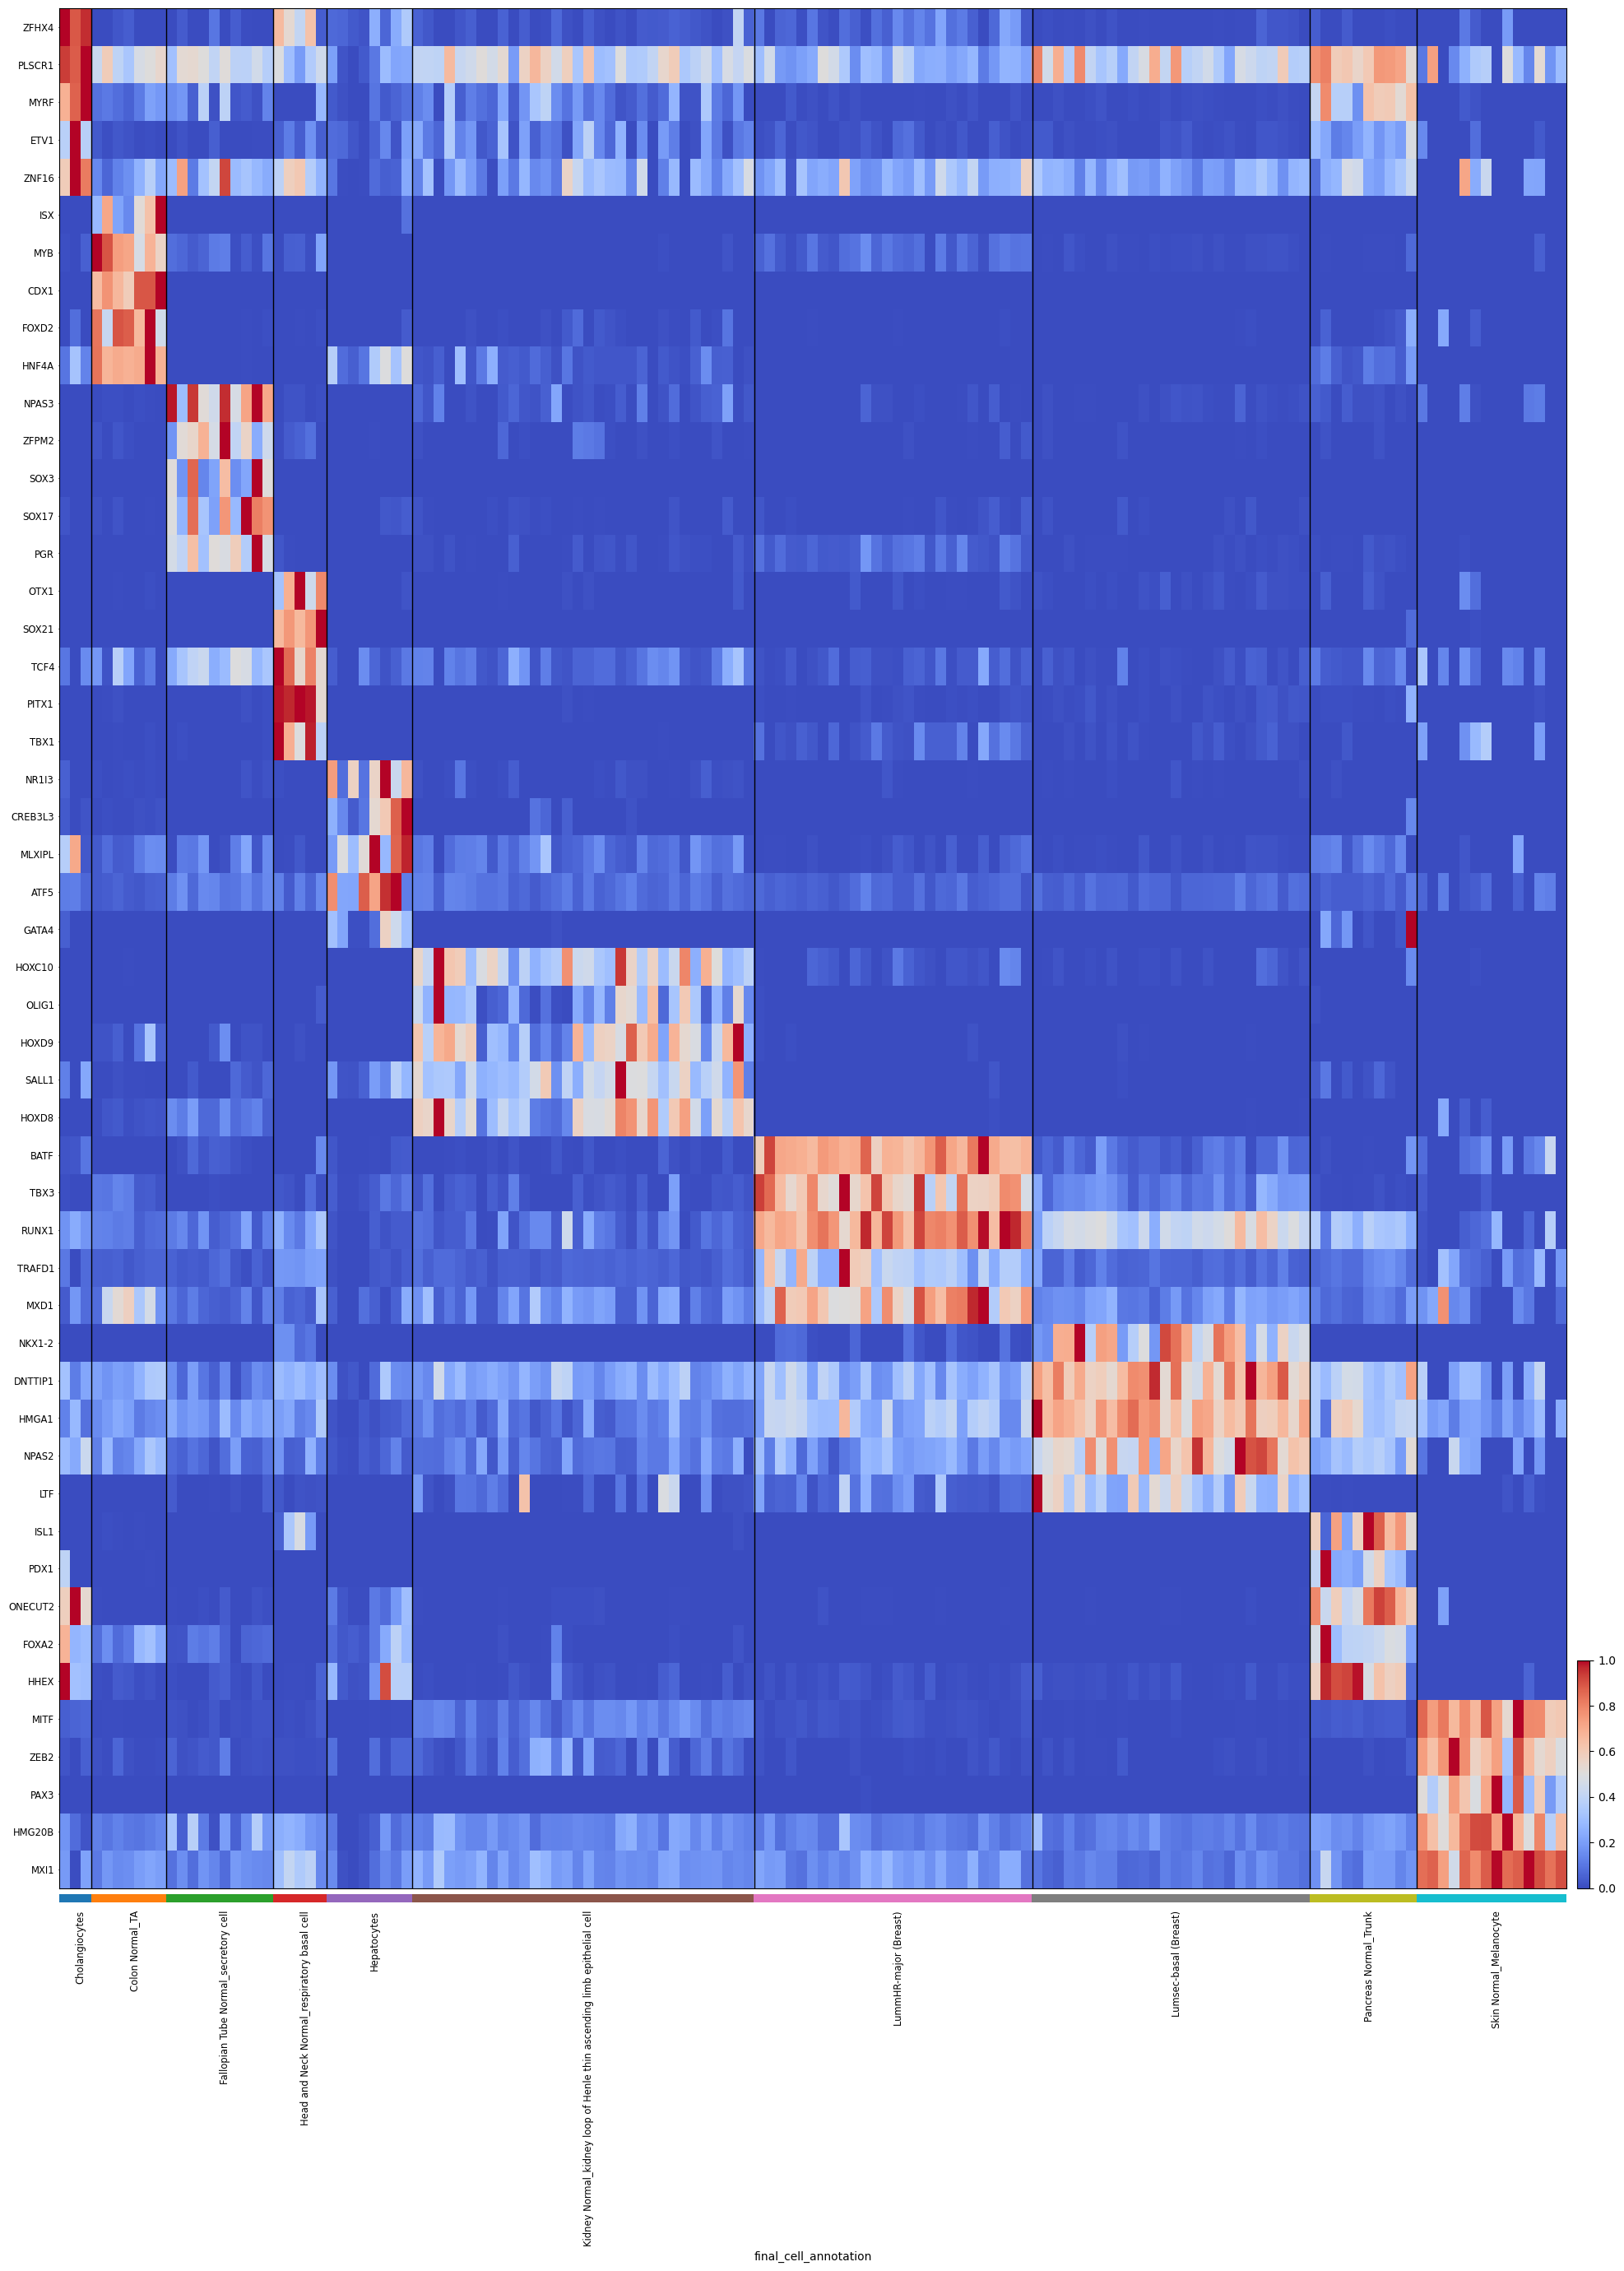

In [ ]:
# View the Heatmap
normal_pseudobulk.obs["final_cell_annotation"] = pd.Categorical(
    normal_pseudobulk.obs["final_cell_annotation"],
    categories=desired_order,
    ordered=True,
)

adata_markers = normal_pseudobulk[
    normal_pseudobulk.obs["final_cell_annotation"].sort_values().index
].copy()

sc.pp.scale(adata_markers, zero_center=True, max_value=10)

sc.pl.heatmap(
    adata_markers,
    var_names=all_markers,
    groupby="final_cell_annotation",
    show_gene_labels=True,
    figsize=(24, 30),
    cmap="coolwarm",
    dendrogram=False,
    swap_axes=True,
    use_raw=False,
    standard_scale="var",
    save="heatmap_TF_activity_5_wilcoxon_normal.png",
)

In [ ]:
# Find the most active TFs in Cancer

sc.tl.rank_genes_groups(
    normal_pseudobulk,
    groupby="final_cell_annotation",
    method="wilcoxon",
    n_genes=5,
    use_raw=False,
)

normal_tfs = {}
for ct in normal_pseudobulk.obs["final_cell_annotation"].cat.categories:
    markers = (
        sc.get.rank_genes_groups_df(normal_pseudobulk, group=ct)
        .head(5)["names"]
        .tolist()
    )
    normal_tfs[ct] = markers

In [21]:
normal_tfs

{'Cholangiocytes': ['ZFHX4', 'PLSCR1', 'MYRF', 'ETV1', 'ZNF16'],
 'Colon Normal_TA': ['ISX', 'MYB', 'CDX1', 'FOXD2', 'HNF4A'],
 'Fallopian Tube Normal_secretory cell': ['NPAS3',
  'ZFPM2',
  'SOX3',
  'SOX17',
  'PGR'],
 'Head and Neck Normal_respiratory basal cell': ['OTX1',
  'SOX21',
  'TCF4',
  'PITX1',
  'TBX1'],
 'Hepatocytes': ['NR1I3', 'CREB3L3', 'MLXIPL', 'ATF5', 'GATA4'],
 'Kidney Normal_kidney loop of Henle thin ascending limb epithelial cell': ['HOXC10',
  'OLIG1',
  'HOXD9',
  'SALL1',
  'HOXD8'],
 'LummHR-major (Breast)': ['BATF', 'TBX3', 'RUNX1', 'TRAFD1', 'MXD1'],
 'Lumsec-basal (Breast)': ['NKX1-2', 'DNTTIP1', 'HMGA1', 'NPAS2', 'LTF'],
 'Pancreas Normal_Trunk': ['ISL1', 'PDX1', 'ONECUT2', 'FOXA2', 'HHEX'],
 'Skin Normal_Melanocyte': ['MITF', 'ZEB2', 'PAX3', 'HMG20B', 'MXI1']}

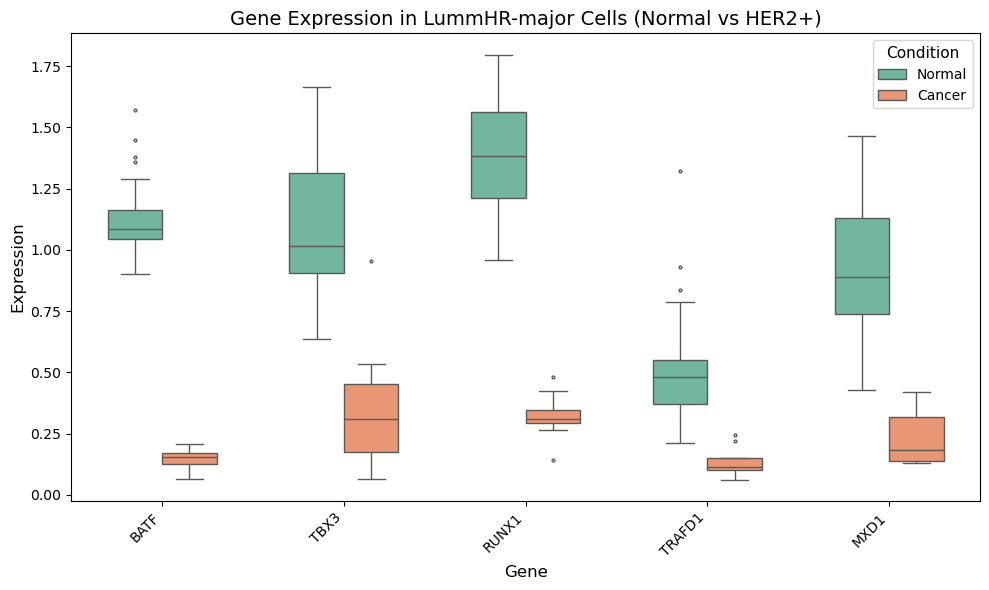

In [ ]:
# View boxplots
genes_of_interest = ["BATF", "TBX3", "RUNX1", "TRAFD1", "MXD1"]

normal_subset = normal_pseudobulk[
    normal_pseudobulk.obs["final_cell_annotation"] == "LummHR-major (Breast)",
    genes_of_interest,
].copy()

cancer_subset = cancer_pseudobulk[
    cancer_pseudobulk.obs["final_cell_annotation"] == "HER2+", genes_of_interest
].copy()

normal_df = pd.DataFrame(normal_subset.X, columns=genes_of_interest)
normal_df["Condition"] = "Normal"

cancer_df = pd.DataFrame(cancer_subset.X, columns=genes_of_interest)
cancer_df["Condition"] = "Cancer"

plot_df = pd.concat([normal_df, cancer_df], ignore_index=True)

plot_df_melted = plot_df.melt(
    id_vars="Condition", var_name="Gene", value_name="Expression"
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plot_df_melted,
    x="Gene",
    y="Expression",
    hue="Condition",
    palette="Set2",
    width=0.6,
    fliersize=2,
)
plt.title("Gene Expression in LummHR-major Cells (Normal vs HER2+)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Gene", fontsize=12)
plt.ylabel("Expression", fontsize=12)
plt.legend(title="Condition", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

# For Cancer

In [23]:
sc.tl.rank_genes_groups(
    cancer_pseudobulk, groupby="final_cell_annotation", method="wilcoxon", n_genes=5
)
all_markers = []
for ct in cancer_pseudobulk.obs["final_cell_annotation"].cat.categories:
    markers = (
        sc.get.rank_genes_groups_df(cancer_pseudobulk, group=ct)
        .head(5)["names"]
        .tolist()
    )
    all_markers.extend(markers)

/home/karitskaya/miniconda3/envs/my_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [24]:
len(all_markers)

65

In [25]:
len(adata_pseudobulk_with_tfs.var_names)

1627

In [26]:
desired_order = cancer_pseudobulk.obs.final_cell_annotation.unique()
desired_order

['MEL', 'THCA', 'RCC', 'HCC', 'CHOL', ..., 'OV', 'TNBC', 'HER2+', 'ER+', 'UVM']
Length: 13
Categories (13, object): ['CHOL', 'CRC', 'ER+', 'HCC', ..., 'RCC', 'THCA', 'TNBC', 'UVM']

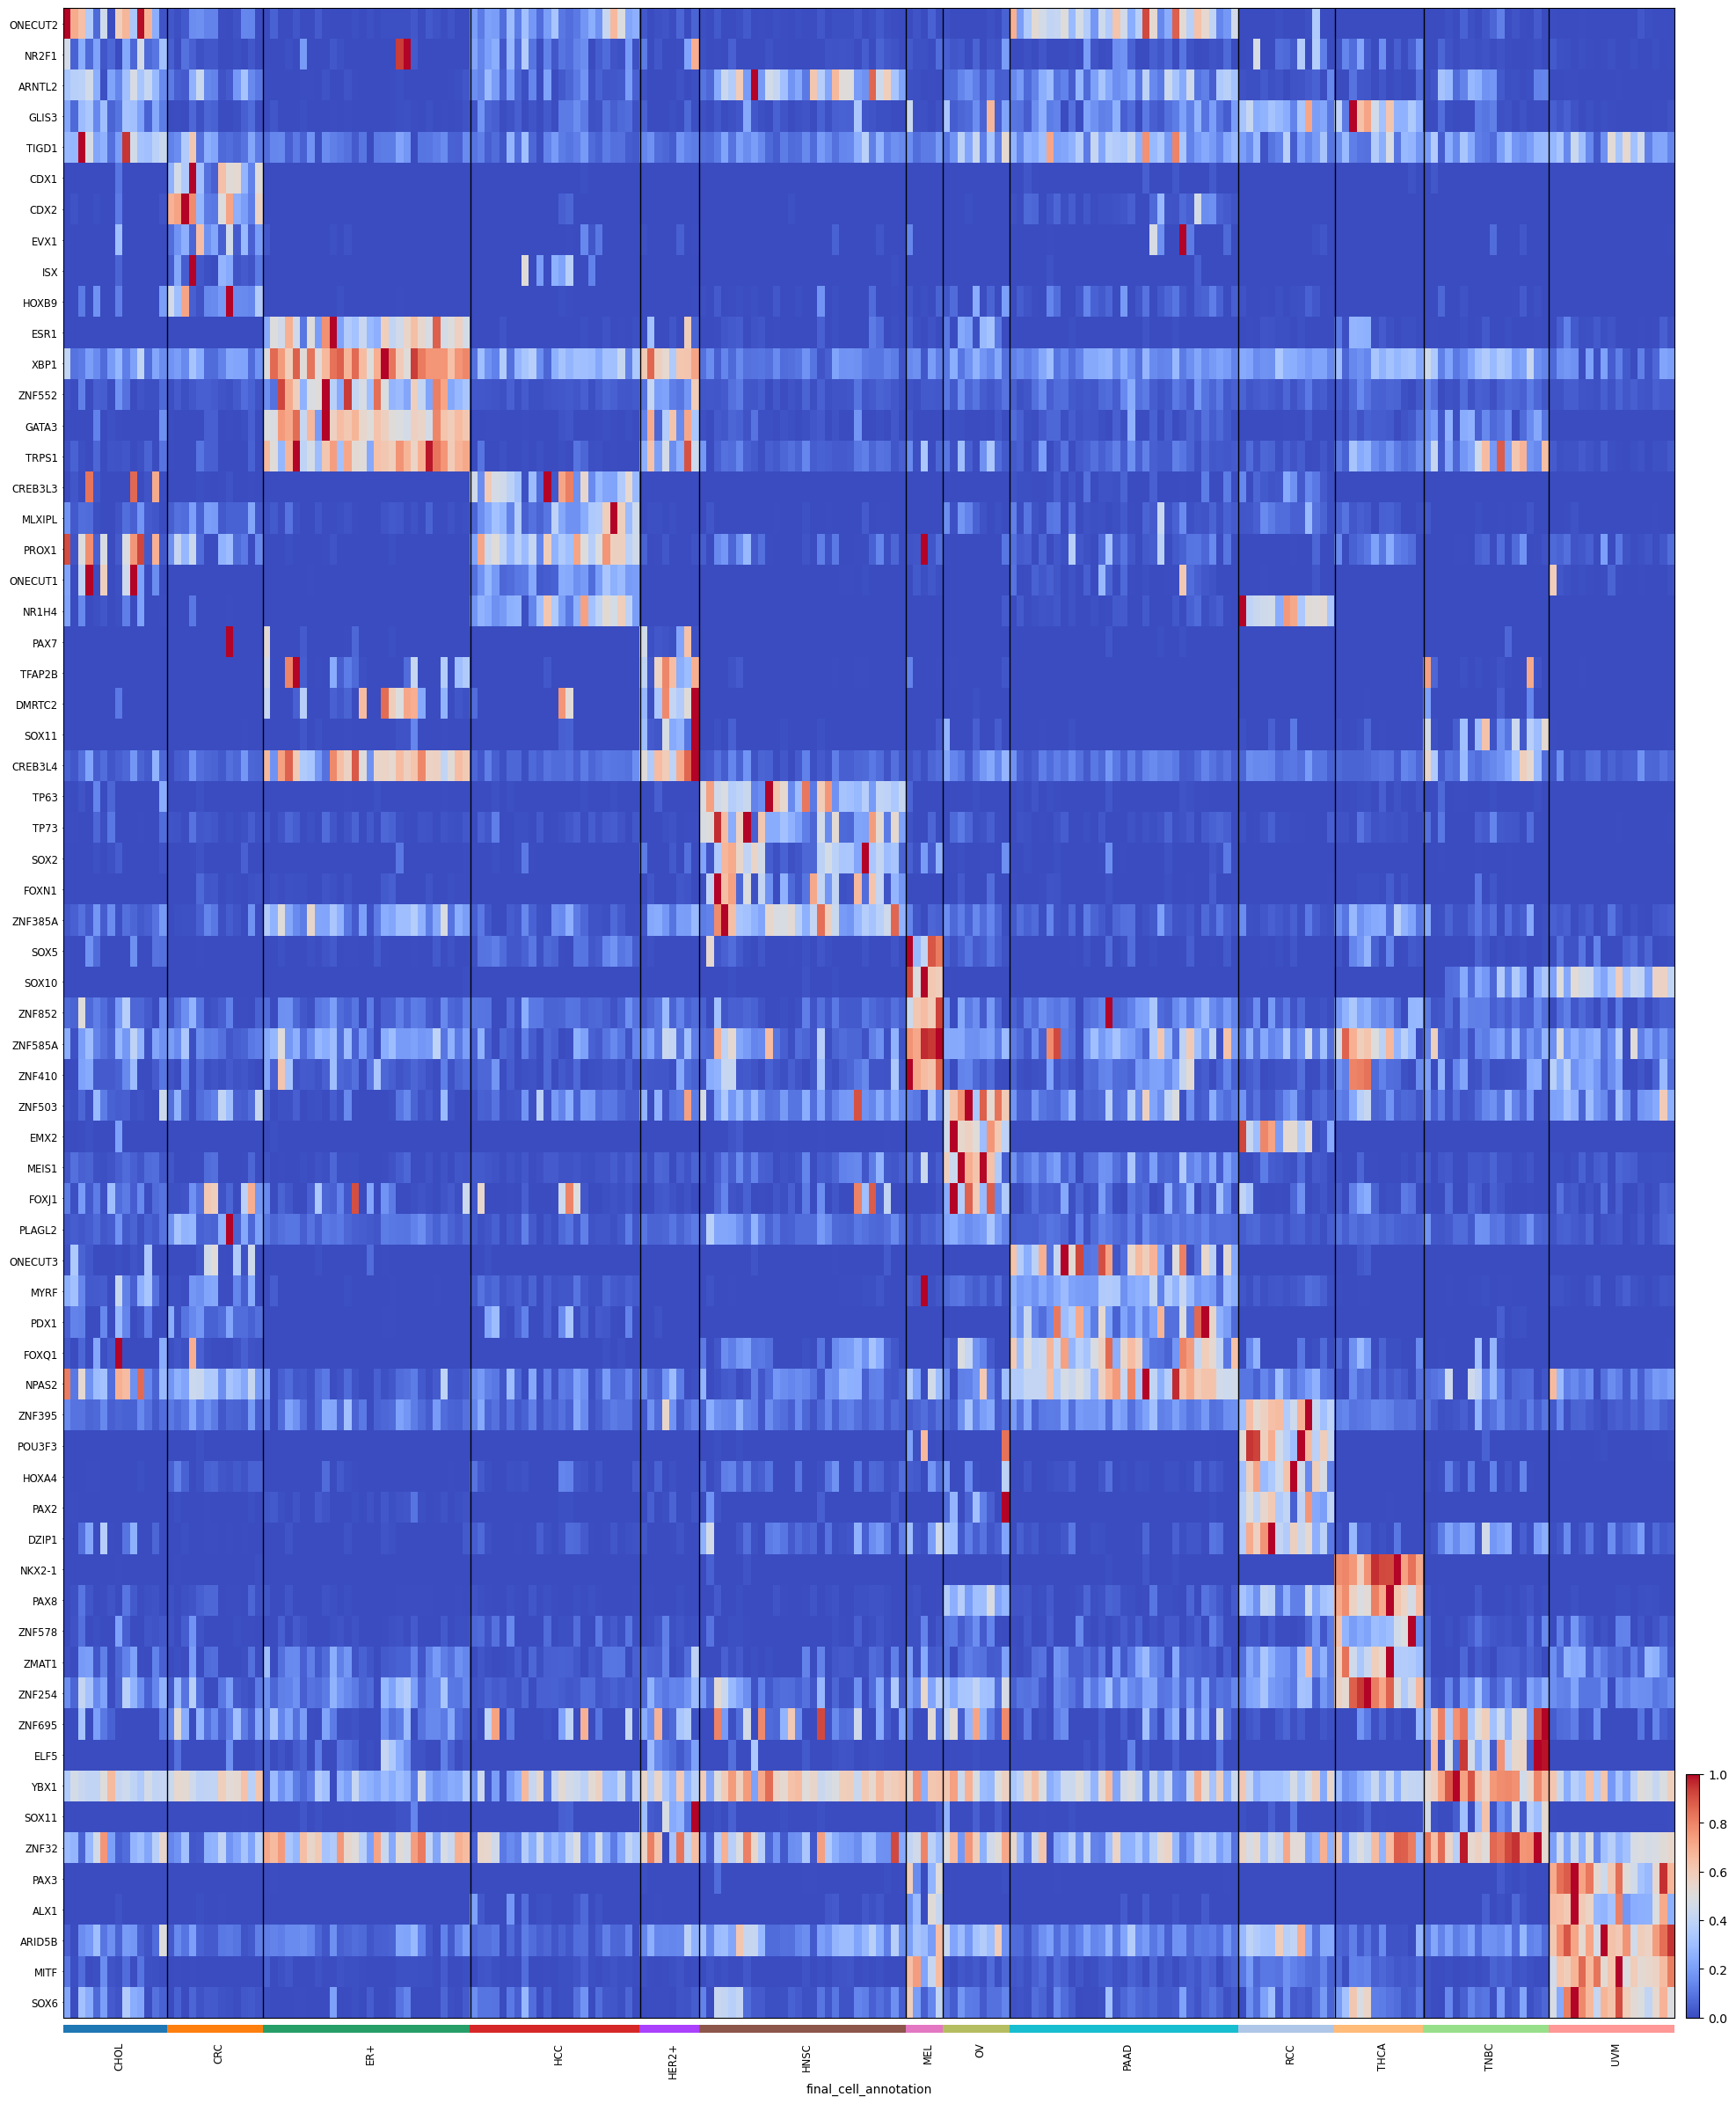

In [ ]:
# View the Heatmap for Cancers TFs
cancer_pseudobulk.obs["final_cell_annotation"] = pd.Categorical(
    cancer_pseudobulk.obs["final_cell_annotation"],
    categories=desired_order,
    ordered=True,
)

adata_markers = cancer_pseudobulk[
    cancer_pseudobulk.obs["final_cell_annotation"].sort_values().index
].copy()

sc.pp.scale(adata_markers, zero_center=True, max_value=10)

sc.pl.heatmap(
    adata_markers,
    var_names=all_markers,
    groupby="final_cell_annotation",
    show_gene_labels=True,
    figsize=(24, 30),
    cmap="coolwarm",
    dendrogram=False,
    swap_axes=True,
    use_raw=False,
    standard_scale="var",
    save="heatmap_TF_activity_5_wilcoxon_cancer.png",
)

In [28]:
sc.tl.rank_genes_groups(
    cancer_pseudobulk,
    groupby="final_cell_annotation",
    method="wilcoxon",
    n_genes=5,
    use_raw=False,
)

cancer_tfs = {}
for ct in cancer_pseudobulk.obs["final_cell_annotation"].cat.categories:
    markers = (
        sc.get.rank_genes_groups_df(cancer_pseudobulk, group=ct)
        .head(5)["names"]
        .tolist()
    )
    cancer_tfs[ct] = markers

In [30]:
cancer_tfs

{'CHOL': ['ONECUT2', 'NR2F1', 'ARNTL2', 'GLIS3', 'TIGD1'],
 'CRC': ['CDX1', 'CDX2', 'EVX1', 'ISX', 'HOXB9'],
 'ER+': ['ESR1', 'XBP1', 'ZNF552', 'GATA3', 'TRPS1'],
 'HCC': ['CREB3L3', 'MLXIPL', 'PROX1', 'ONECUT1', 'NR1H4'],
 'HER2+': ['PAX7', 'TFAP2B', 'DMRTC2', 'SOX11', 'CREB3L4'],
 'HNSC': ['TP63', 'TP73', 'SOX2', 'FOXN1', 'ZNF385A'],
 'MEL': ['SOX5', 'SOX10', 'ZNF852', 'ZNF585A', 'ZNF410'],
 'OV': ['ZNF503', 'EMX2', 'MEIS1', 'FOXJ1', 'PLAGL2'],
 'PAAD': ['ONECUT3', 'MYRF', 'PDX1', 'FOXQ1', 'NPAS2'],
 'RCC': ['ZNF395', 'POU3F3', 'HOXA4', 'PAX2', 'DZIP1'],
 'THCA': ['NKX2-1', 'PAX8', 'ZNF578', 'ZMAT1', 'ZNF254'],
 'TNBC': ['ZNF695', 'ELF5', 'YBX1', 'SOX11', 'ZNF32'],
 'UVM': ['PAX3', 'ALX1', 'ARID5B', 'MITF', 'SOX6']}

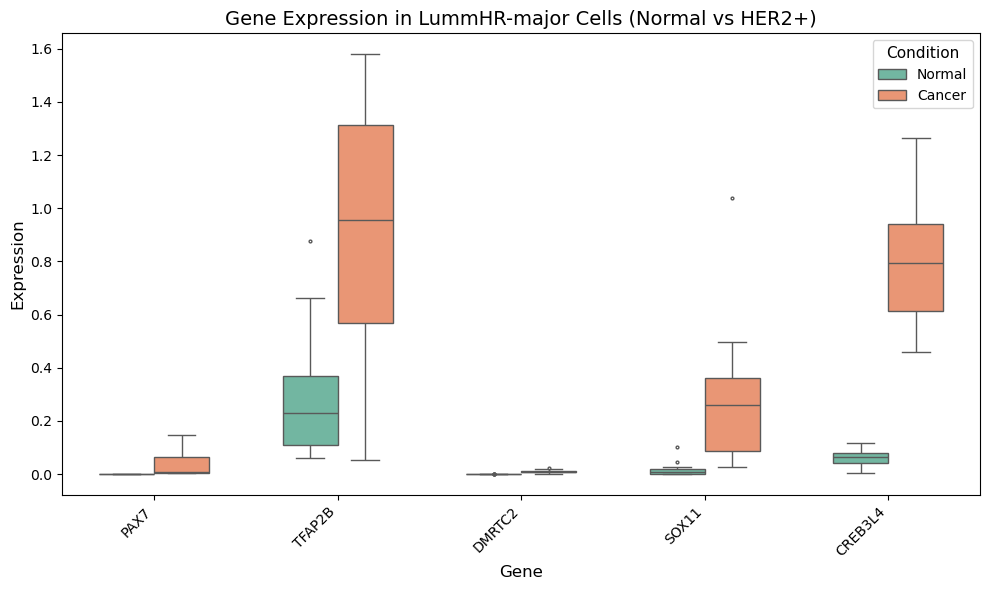

In [ ]:
# View boxplots
genes_of_interest = ["PAX7", "TFAP2B", "DMRTC2", "SOX11", "CREB3L4"]

normal_subset = normal_pseudobulk[
    normal_pseudobulk.obs["final_cell_annotation"] == "LummHR-major (Breast)",
    genes_of_interest,
].copy()

cancer_subset = cancer_pseudobulk[
    cancer_pseudobulk.obs["final_cell_annotation"] == "HER2+", genes_of_interest
].copy()

normal_df = pd.DataFrame(normal_subset.X, columns=genes_of_interest)
normal_df["Condition"] = "Normal"

cancer_df = pd.DataFrame(cancer_subset.X, columns=genes_of_interest)
cancer_df["Condition"] = "Cancer"

plot_df = pd.concat([normal_df, cancer_df], ignore_index=True)

plot_df_melted = plot_df.melt(
    id_vars="Condition", var_name="Gene", value_name="Expression"
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plot_df_melted,
    x="Gene",
    y="Expression",
    hue="Condition",
    palette="Set2",
    width=0.6,
    fliersize=2,
)
plt.title("Gene Expression in LummHR-major Cells (Normal vs HER2+)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Gene", fontsize=12)
plt.ylabel("Expression", fontsize=12)
plt.legend(title="Condition", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [31]:
cancer_normal_pairs = [
    ("Cholangiocytes", "CHOL"),
    ("Skin Normal_Melanocyte", "MEL"),
    ("Skin Normal_Melanocyte", "UVM"),
    ("Kidney Normal_kidney loop of Henle thin ascending limb epithelial cell", "RCC"),
    ("Colon Normal_TA", "CRC"),
    ("Hepatocytes", "HCC"),
    ("Fallopian Tube Normal_secretory cell", "OV"),
    ("Head and Neck Normal_respiratory basal cell", "HNSC"),
    ("Pancreas Normal_Trunk", "PAAD"),
    ("Lumsec-basal (Breast)", "TNBC"),
    ("LummHR-major (Breast)", "ER+"),
    ("LummHR-major (Breast)", "HER2+"),
]

In [ ]:
# The function to plot scatterplots for Cancer and Normal TFs
def plot_cancer_vs_normal(
    normal_type, cancer_type, normal_tfs, cancer_tfs, normal_data, cancer_data
):
    normal_specific = normal_tfs.get(normal_type, [])
    cancer_specific = cancer_tfs.get(cancer_type, [])
    all_tfs = list(set(normal_specific + cancer_specific))

    normal_samples = normal_data[
        normal_data.obs["final_cell_annotation"] == normal_type
    ]
    cancer_samples = cancer_data[
        cancer_data.obs["final_cell_annotation"] == cancer_type
    ]

    normal_expression = pd.DataFrame(
        {
            "mean": normal_samples[:, all_tfs].X.mean(axis=0),
            "std": normal_samples[:, all_tfs].X.std(axis=0),
        },
        index=all_tfs,
    )

    cancer_expression = pd.DataFrame(
        {
            "mean": cancer_samples[:, all_tfs].X.mean(axis=0),
            "std": cancer_samples[:, all_tfs].X.std(axis=0),
        },
        index=all_tfs,
    )

    plot_data = pd.DataFrame(
        {
            "normal": normal_expression["mean"],
            "normal_std": normal_expression["std"],
            "cancer": cancer_expression["mean"],
            "cancer_std": cancer_expression["std"],
        }
    )

    plot_data["specificity"] = "other"
    plot_data.loc[plot_data.index.isin(normal_specific), "specificity"] = "normal"
    plot_data.loc[plot_data.index.isin(cancer_specific), "specificity"] = "cancer"

    plt.figure(figsize=(14, 12))
    sns.set_style("whitegrid")

    ax = sns.scatterplot(
        data=plot_data,
        x="normal",
        y="cancer",
        hue="specificity",
        palette={"normal": "#7394ff", "cancer": "#ee4566"},
        s=600,
        alpha=0.85,
    )

    for _, row in plot_data.iterrows():
        if row["specificity"] in ["normal", "cancer"]:
            ax.errorbar(
                row["normal"],
                row["cancer"],
                xerr=row["normal_std"],
                yerr=row["cancer_std"],
                fmt="none",
                ecolor="black",
                elinewidth=1.2,
                capsize=6,
                alpha=0.4,
            )

    for spec, color in [("normal", "blue"), ("cancer", "red")]:
        subset = plot_data[plot_data["specificity"] == spec]
        if len(subset) > 1:
            cov = np.cov(subset["normal"], subset["cancer"])
            pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
            ell_radius_x = np.sqrt(1 + pearson)
            ell_radius_y = np.sqrt(1 - pearson)
            ellipse = Ellipse(
                (0, 0),
                width=ell_radius_x * 2,
                height=ell_radius_y * 2,
                facecolor=color,
                alpha=0.15,
            )

            mean_x, mean_y = subset["normal"].mean(), subset["cancer"].mean()
            ax.add_patch(ellipse)
            ellipse.set_transform(
                transforms.Affine2D()
                .rotate_deg(45)
                .scale(np.sqrt(cov[0, 0]) * 2, np.sqrt(cov[1, 1]) * 2)
                .translate(mean_x, mean_y)
            )

    lims = [0, max(plot_data[["normal", "cancer"]].max().max(), 1)]
    ax.plot(lims, lims, "k--", linewidth=1.5, alpha=0.8, zorder=0, dashes=(5, 5))
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    for tf in normal_specific + cancer_specific:
        ax.text(
            plot_data.loc[tf, "normal"],
            plot_data.loc[tf, "cancer"],
            tf,
            fontsize=26,
            ha="center",
            va="bottom",
        )

    ax.set_title(f"{cancer_type} vs {normal_type}", fontsize=26)
    ax.set_xlabel("Expression in Normal", fontsize=24)
    ax.set_ylabel("Expression in Cancer", fontsize=24)
    ax.tick_params(labelsize=13)
    ax.legend(title="Specificity", title_fontsize=26, fontsize=20)

    plt.tight_layout()
    plt.savefig(f"{cancer_type}_vs_{normal_type}.png", dpi=300)
    plt.show()

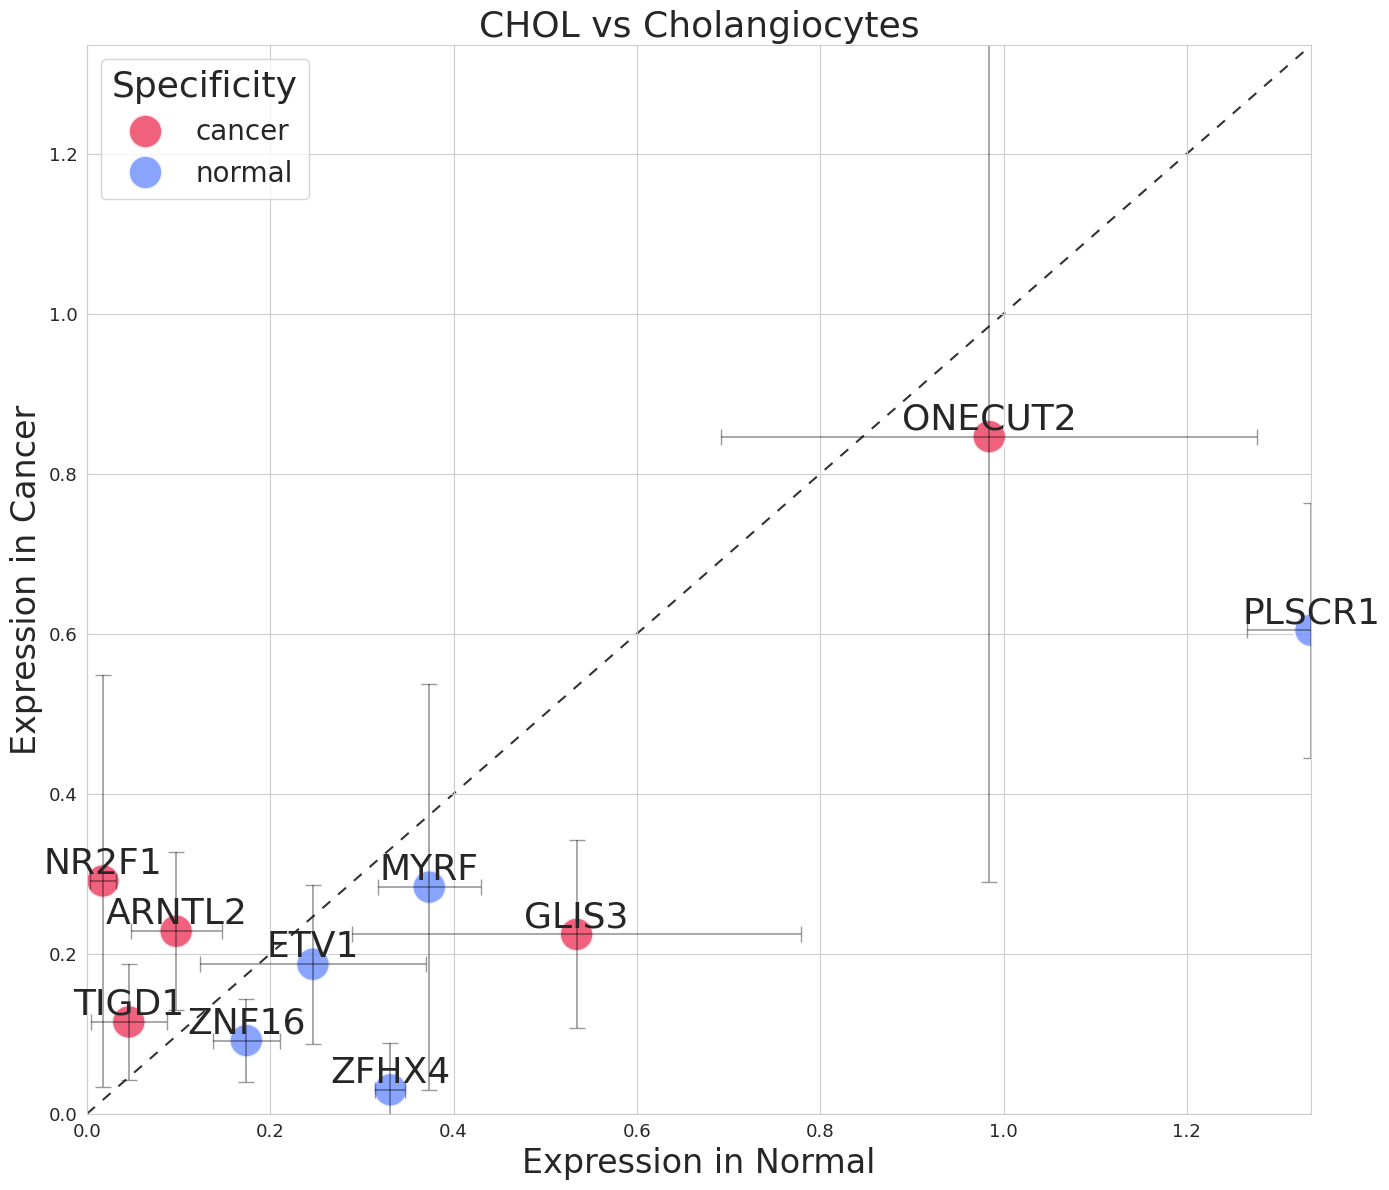

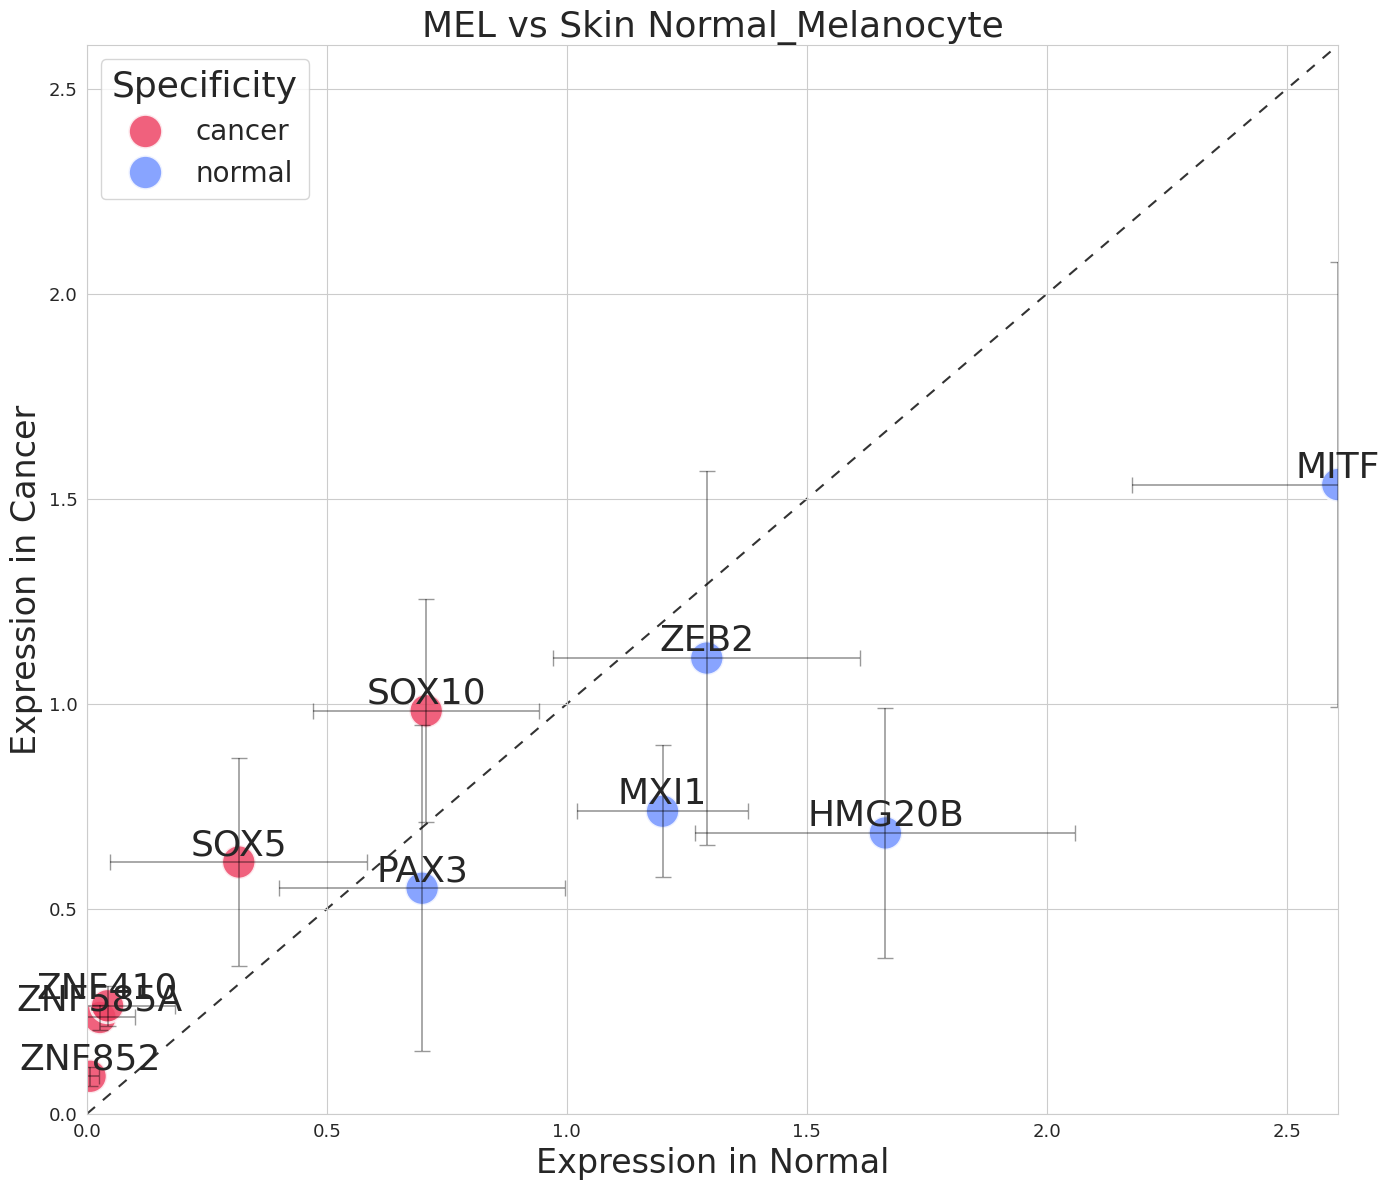

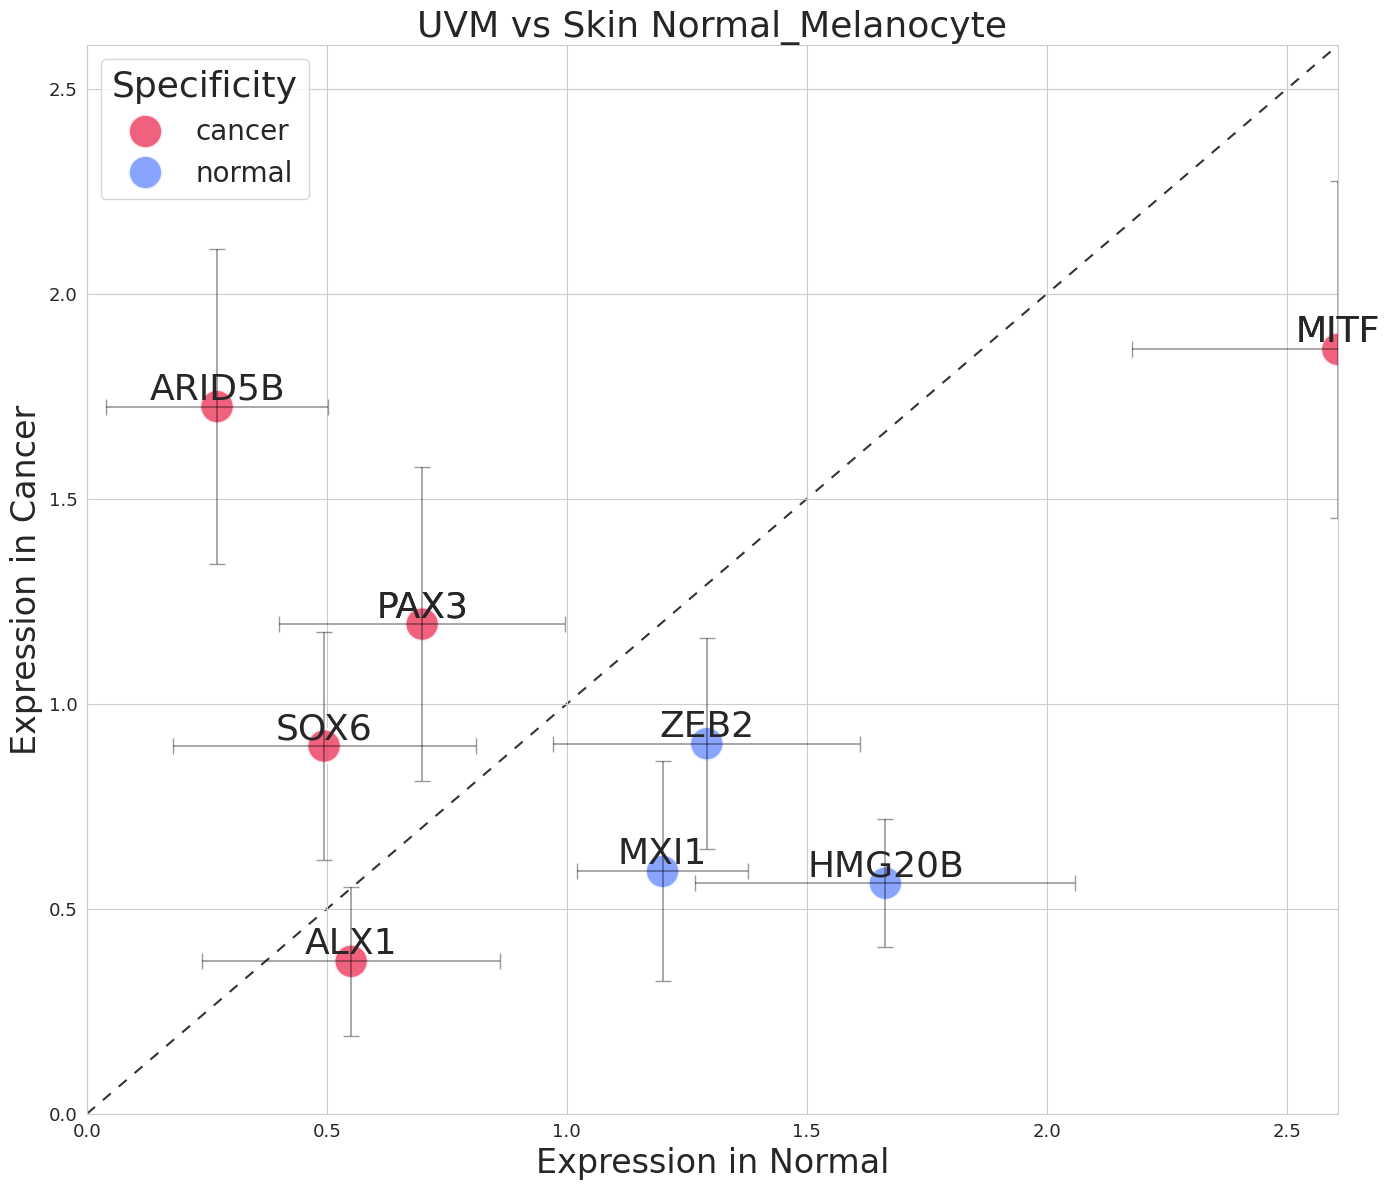

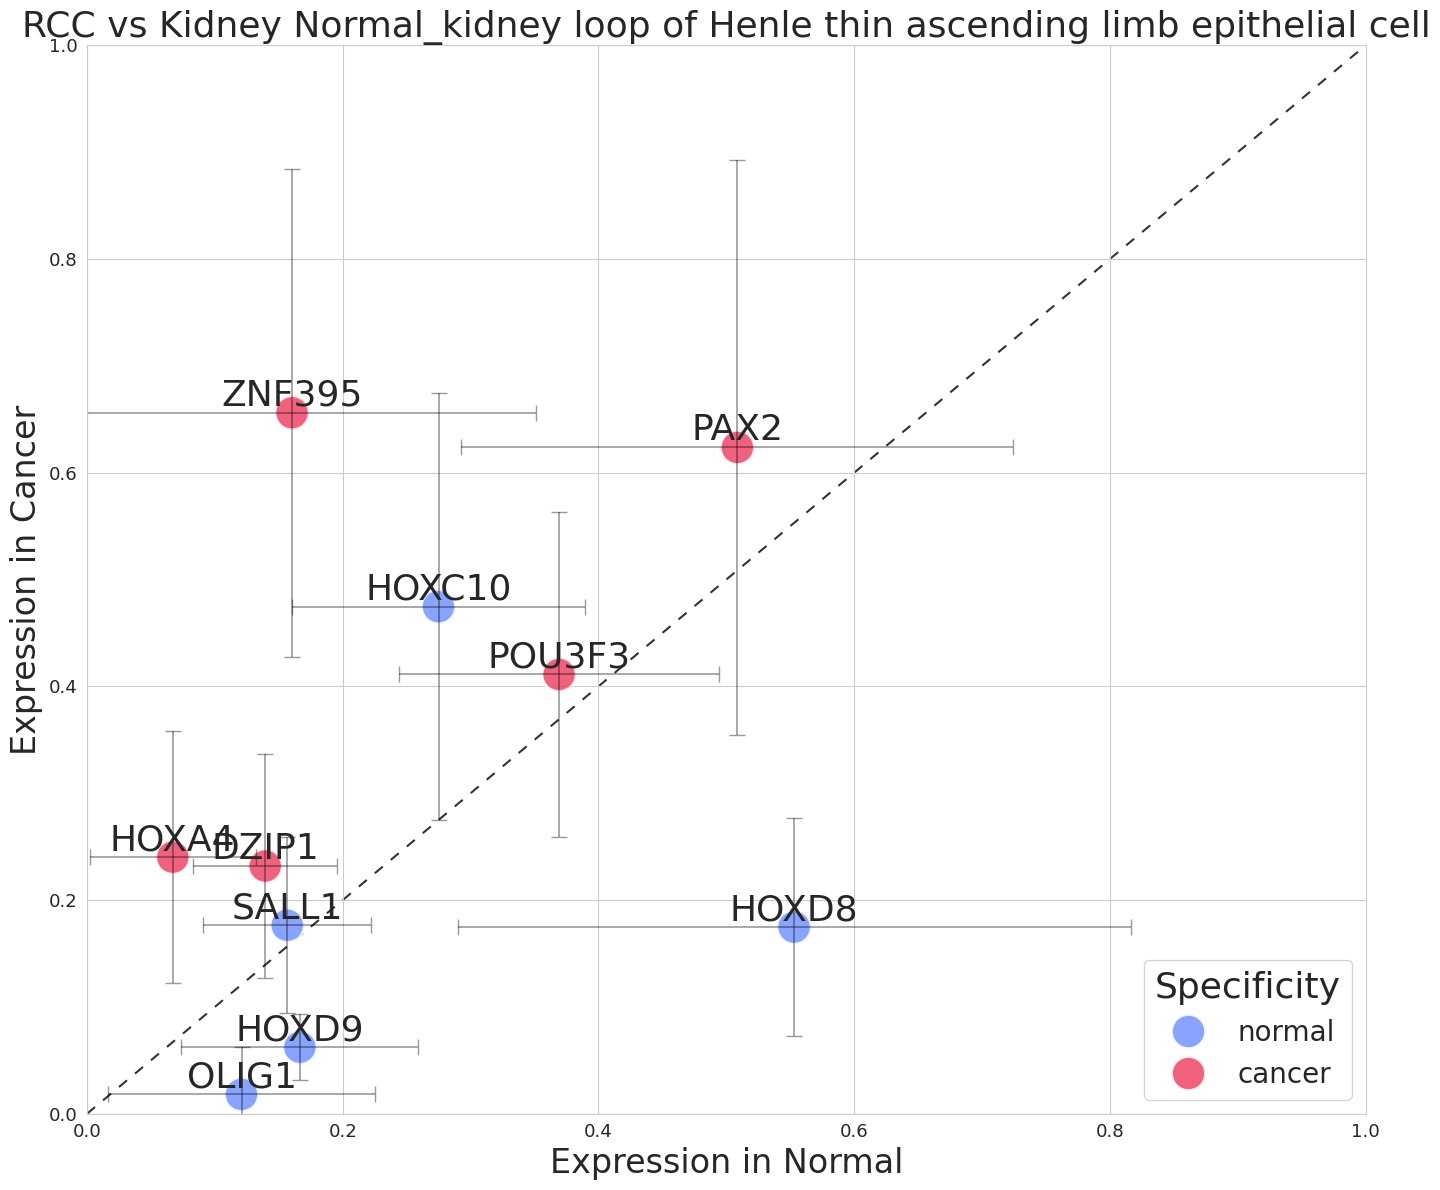

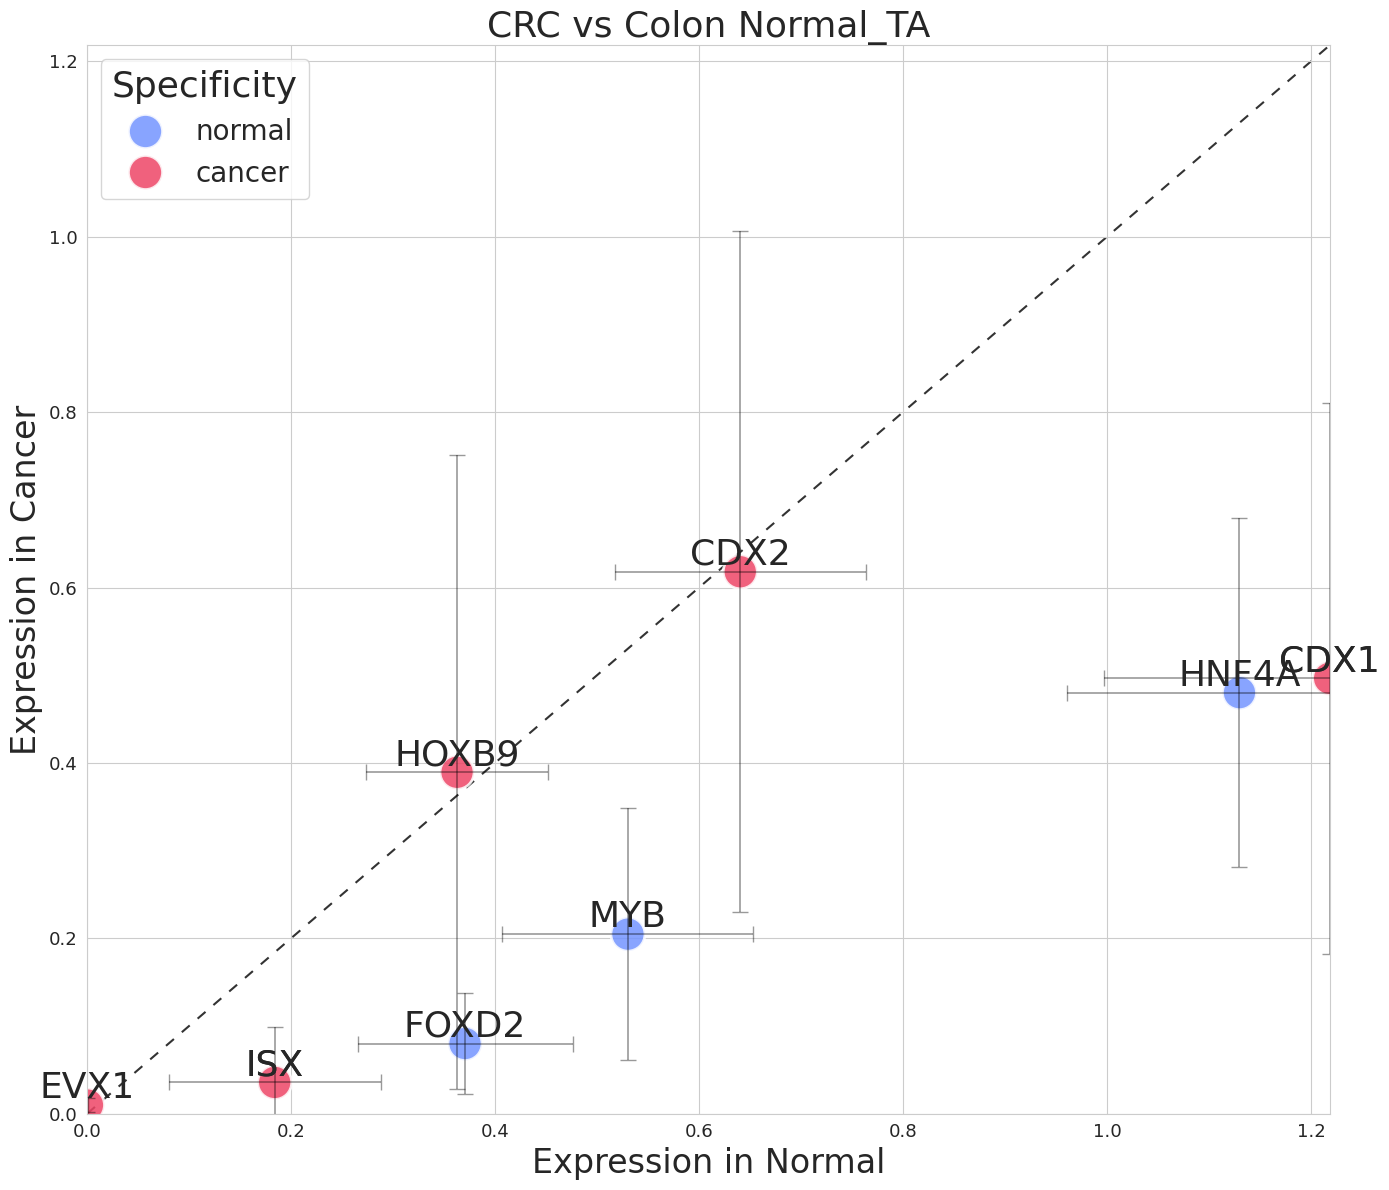

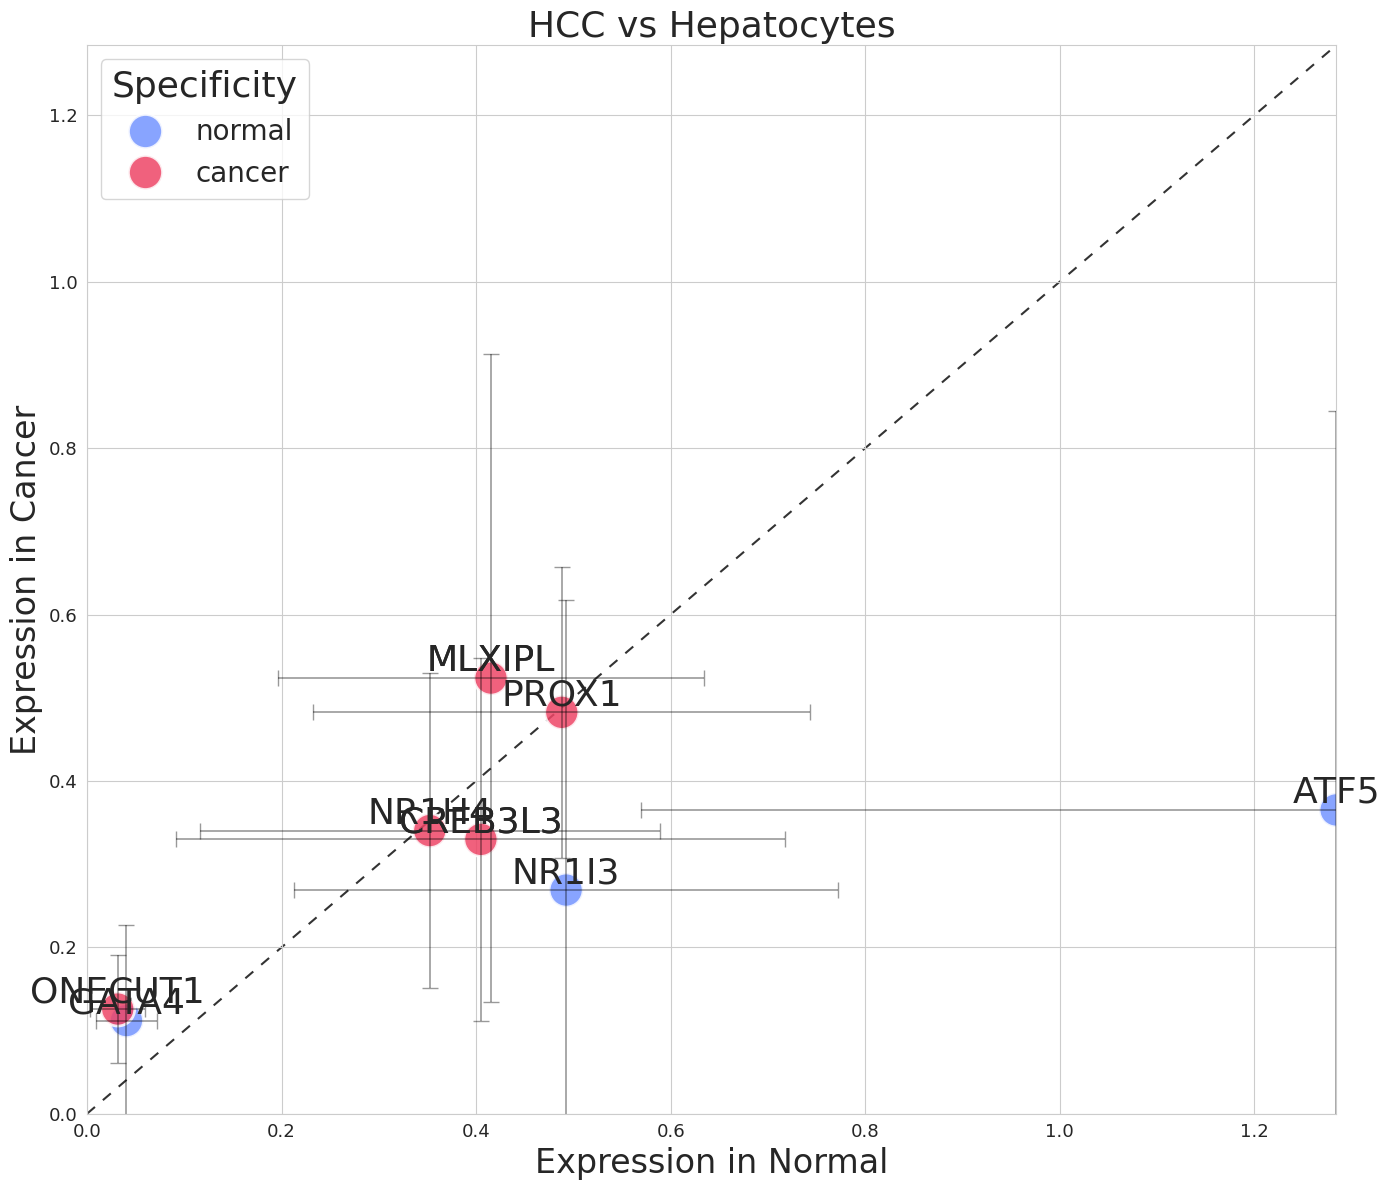

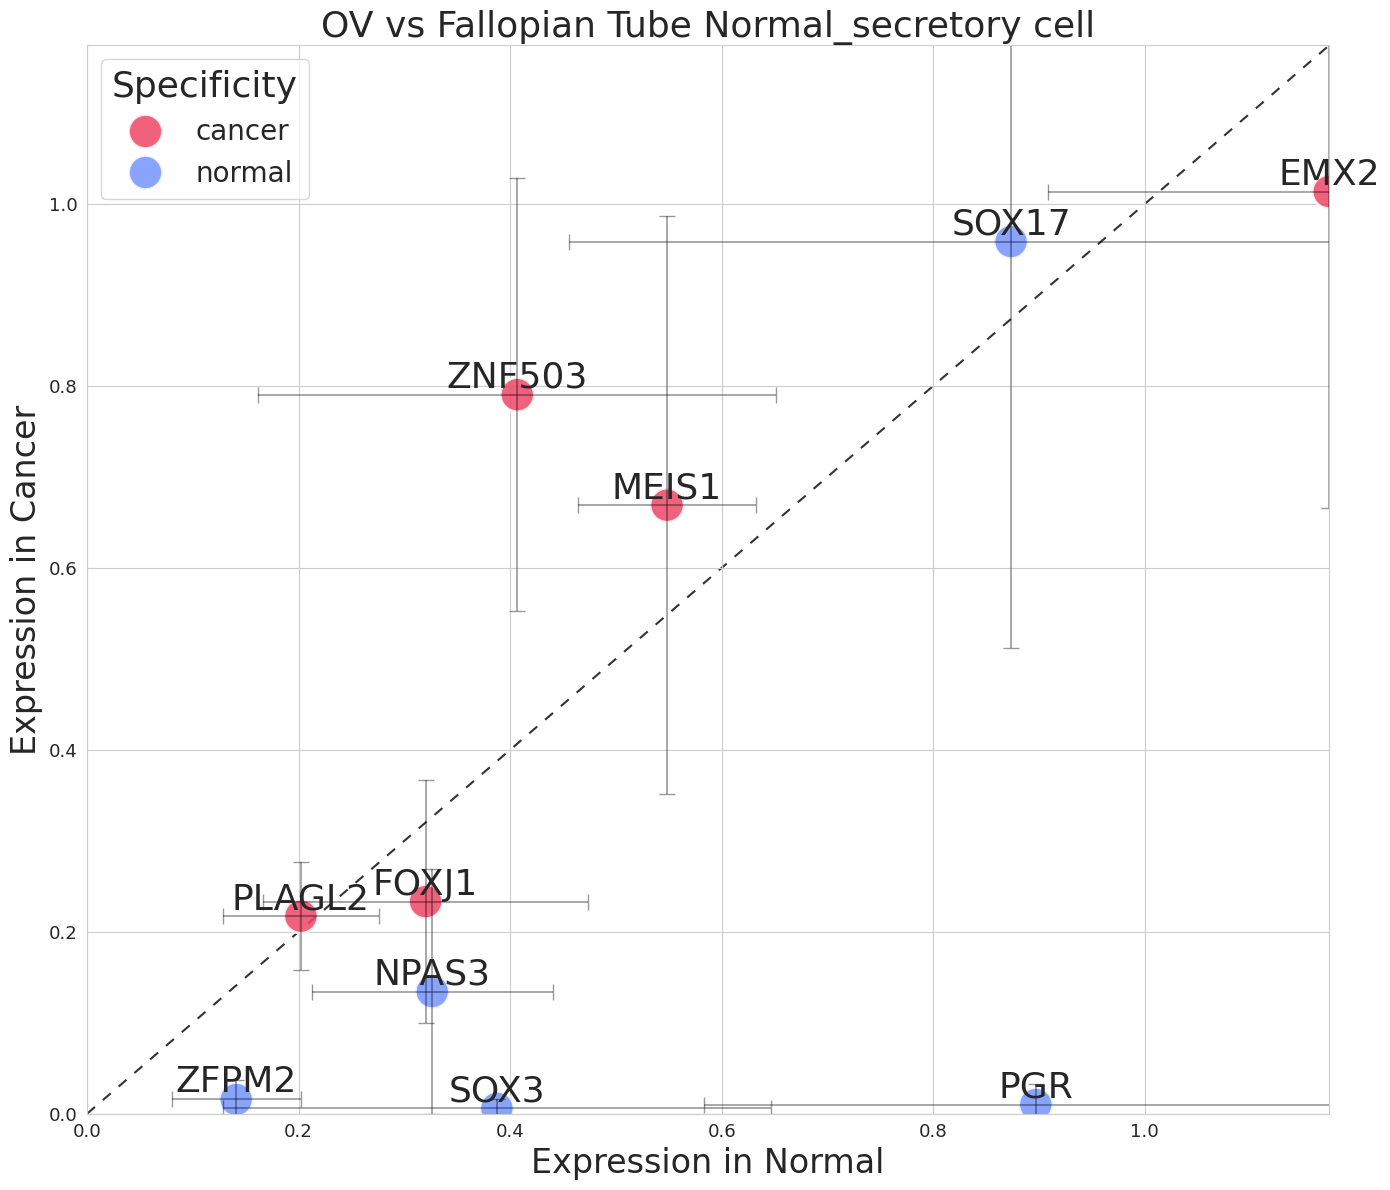

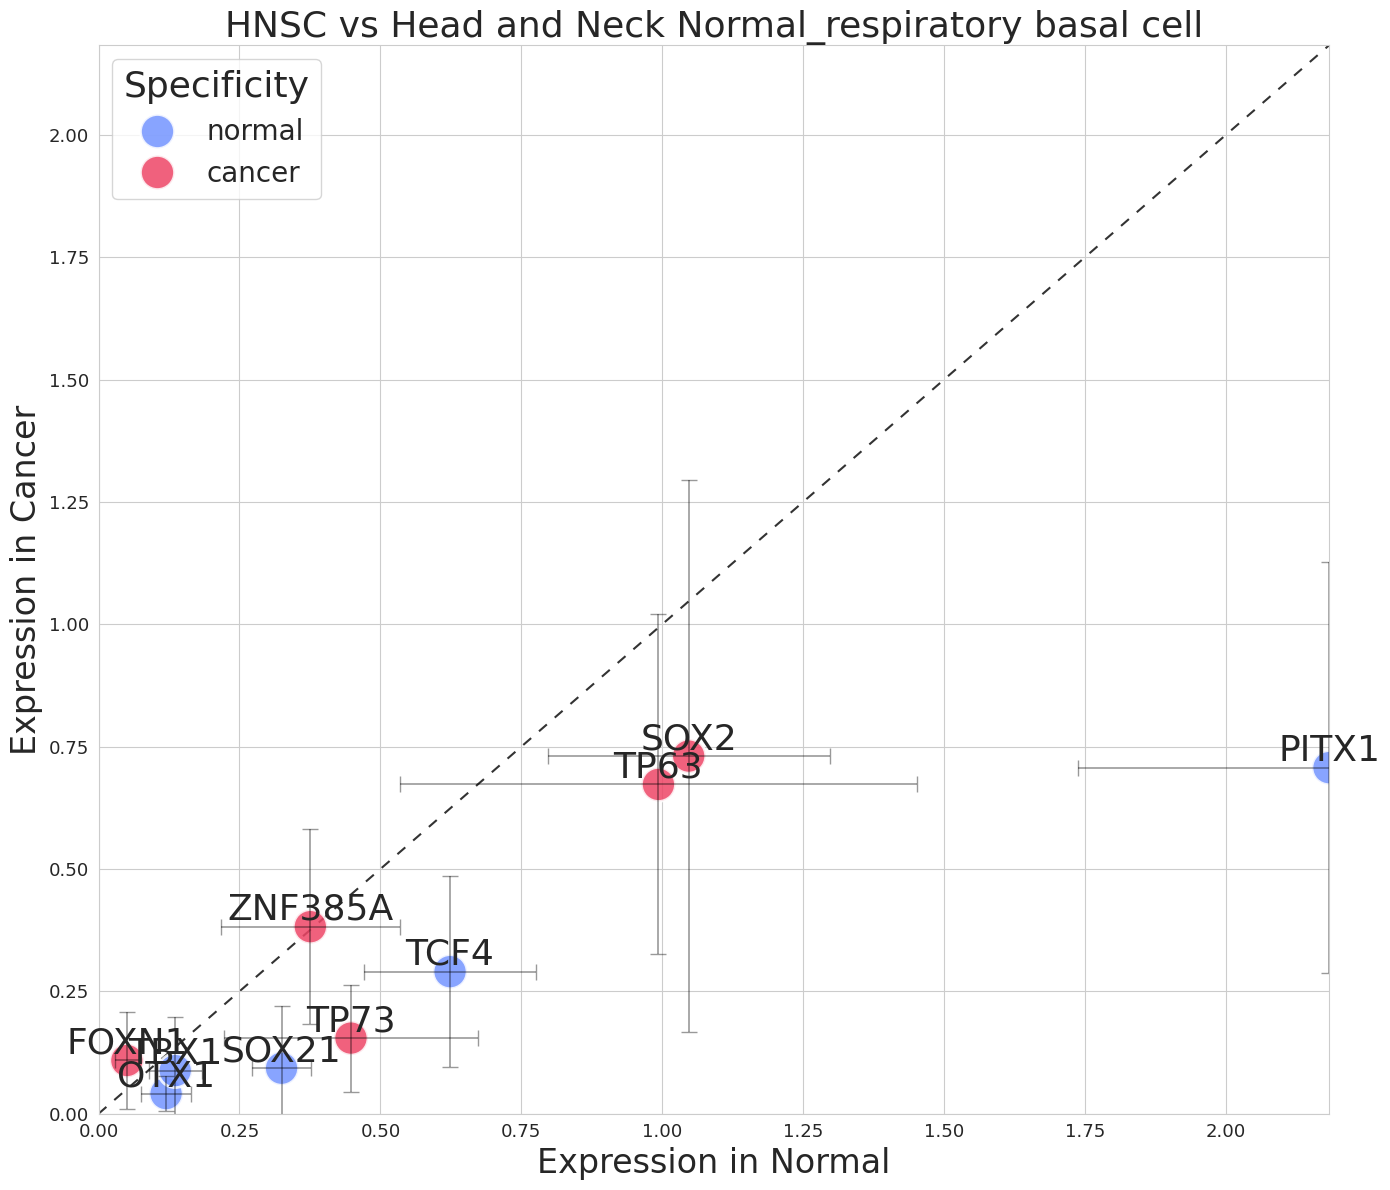

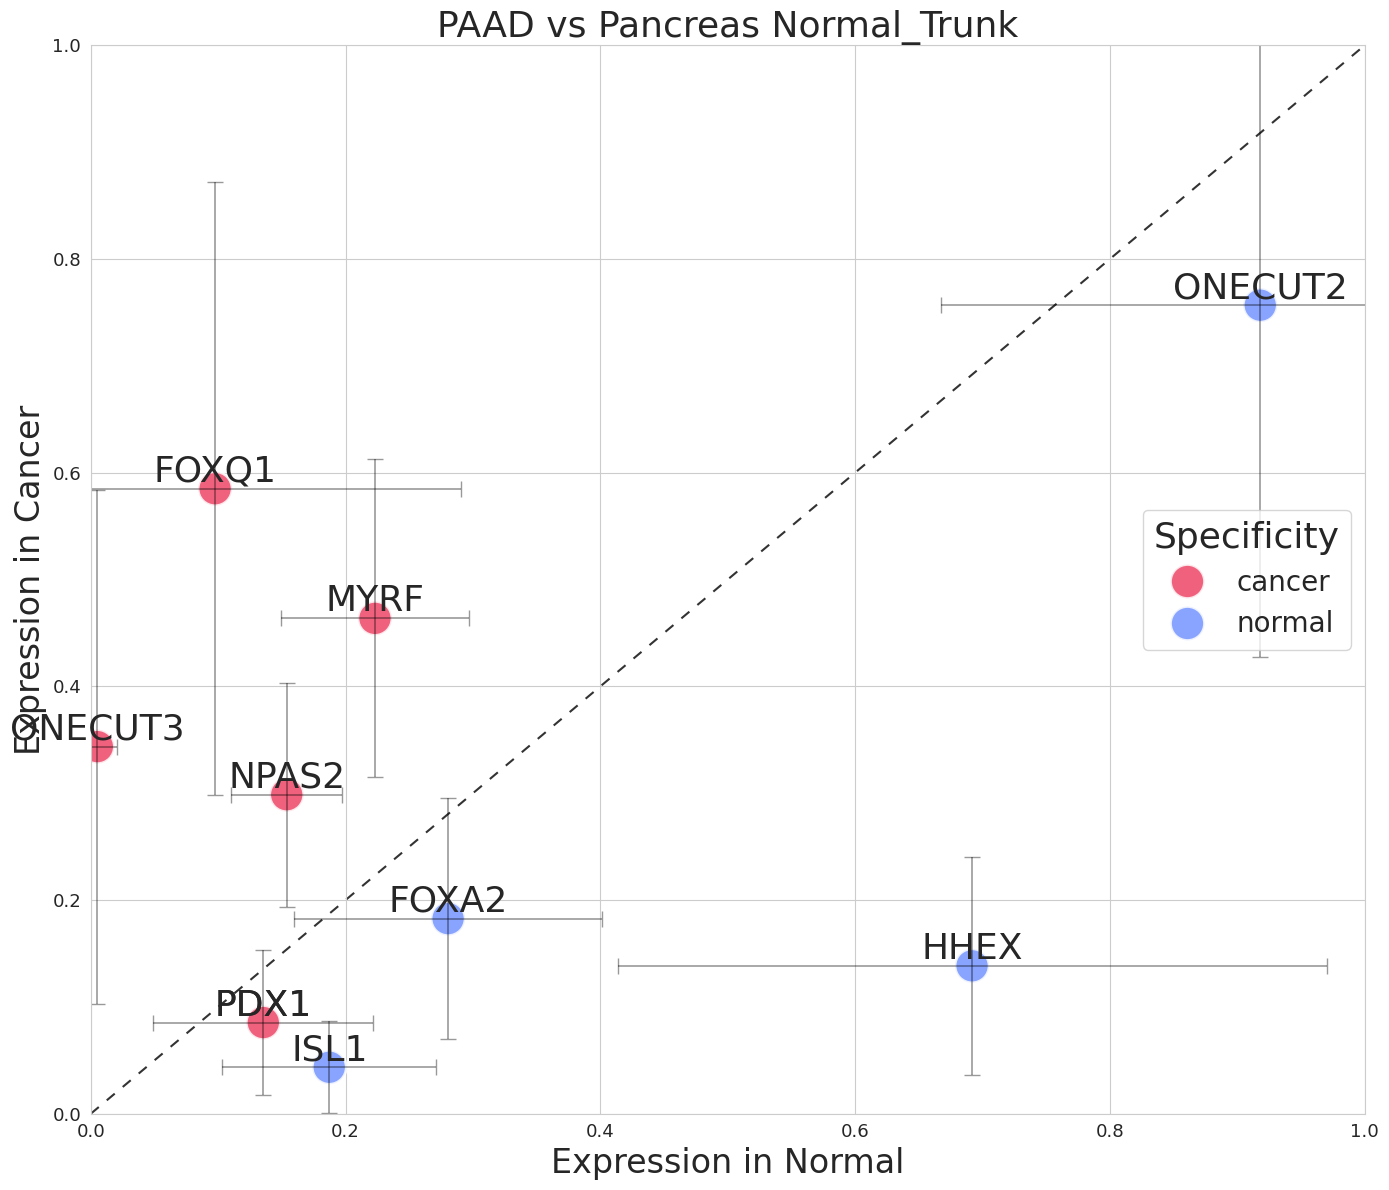

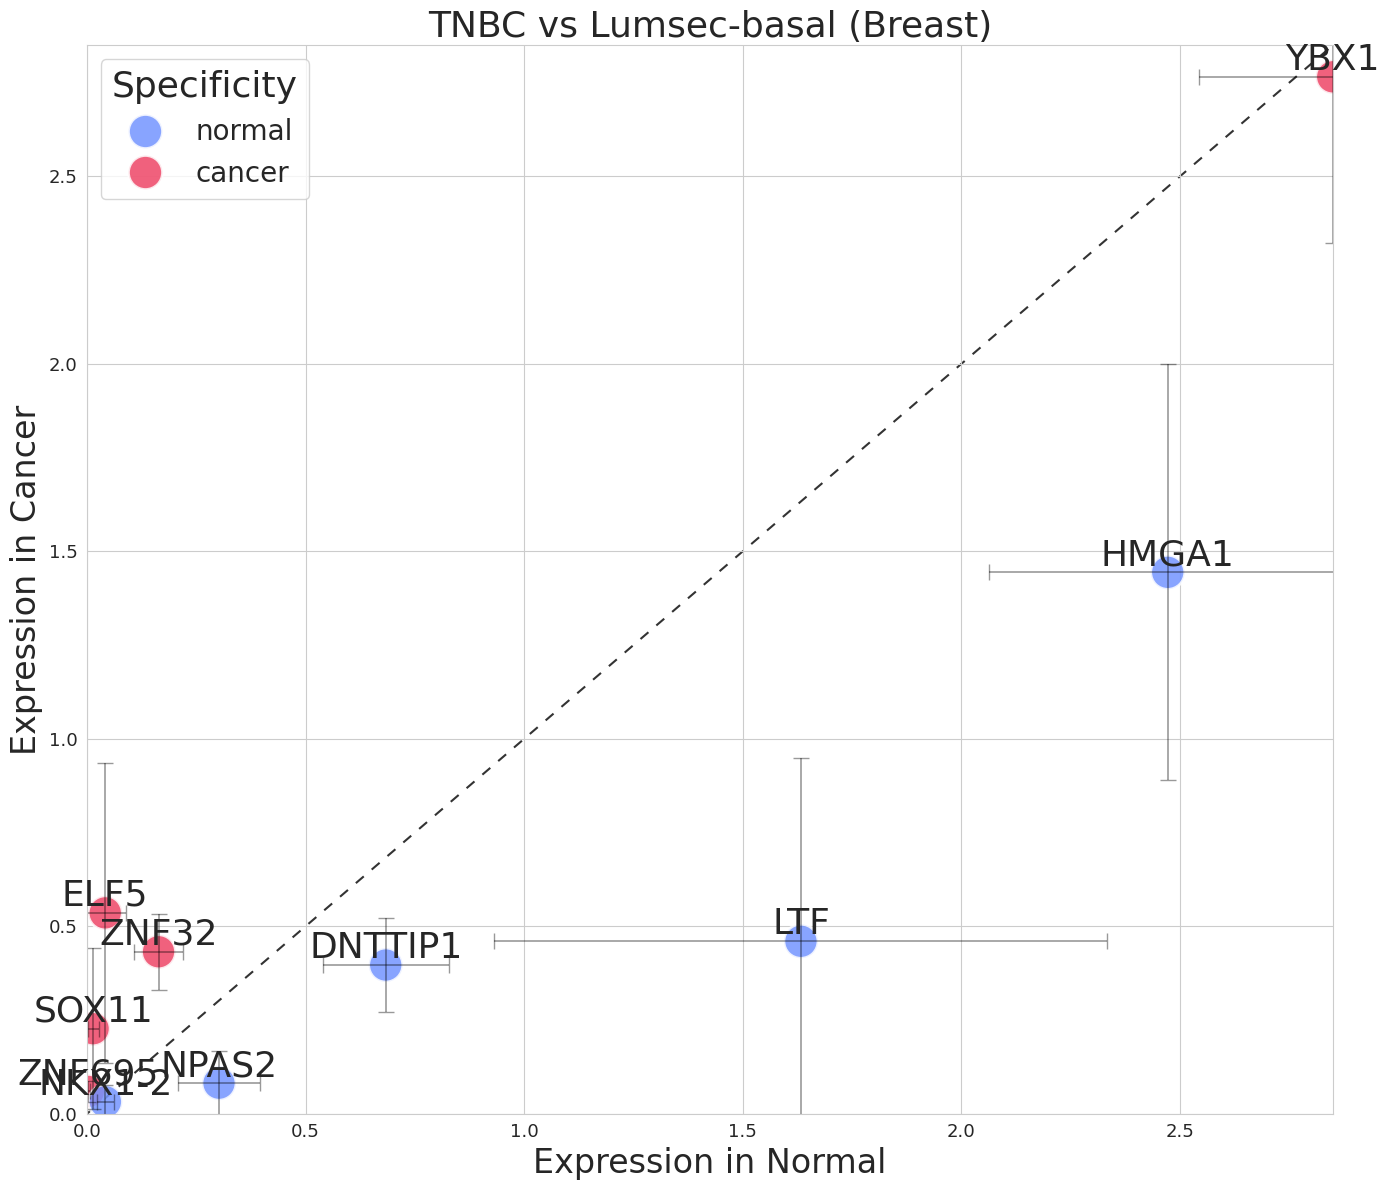

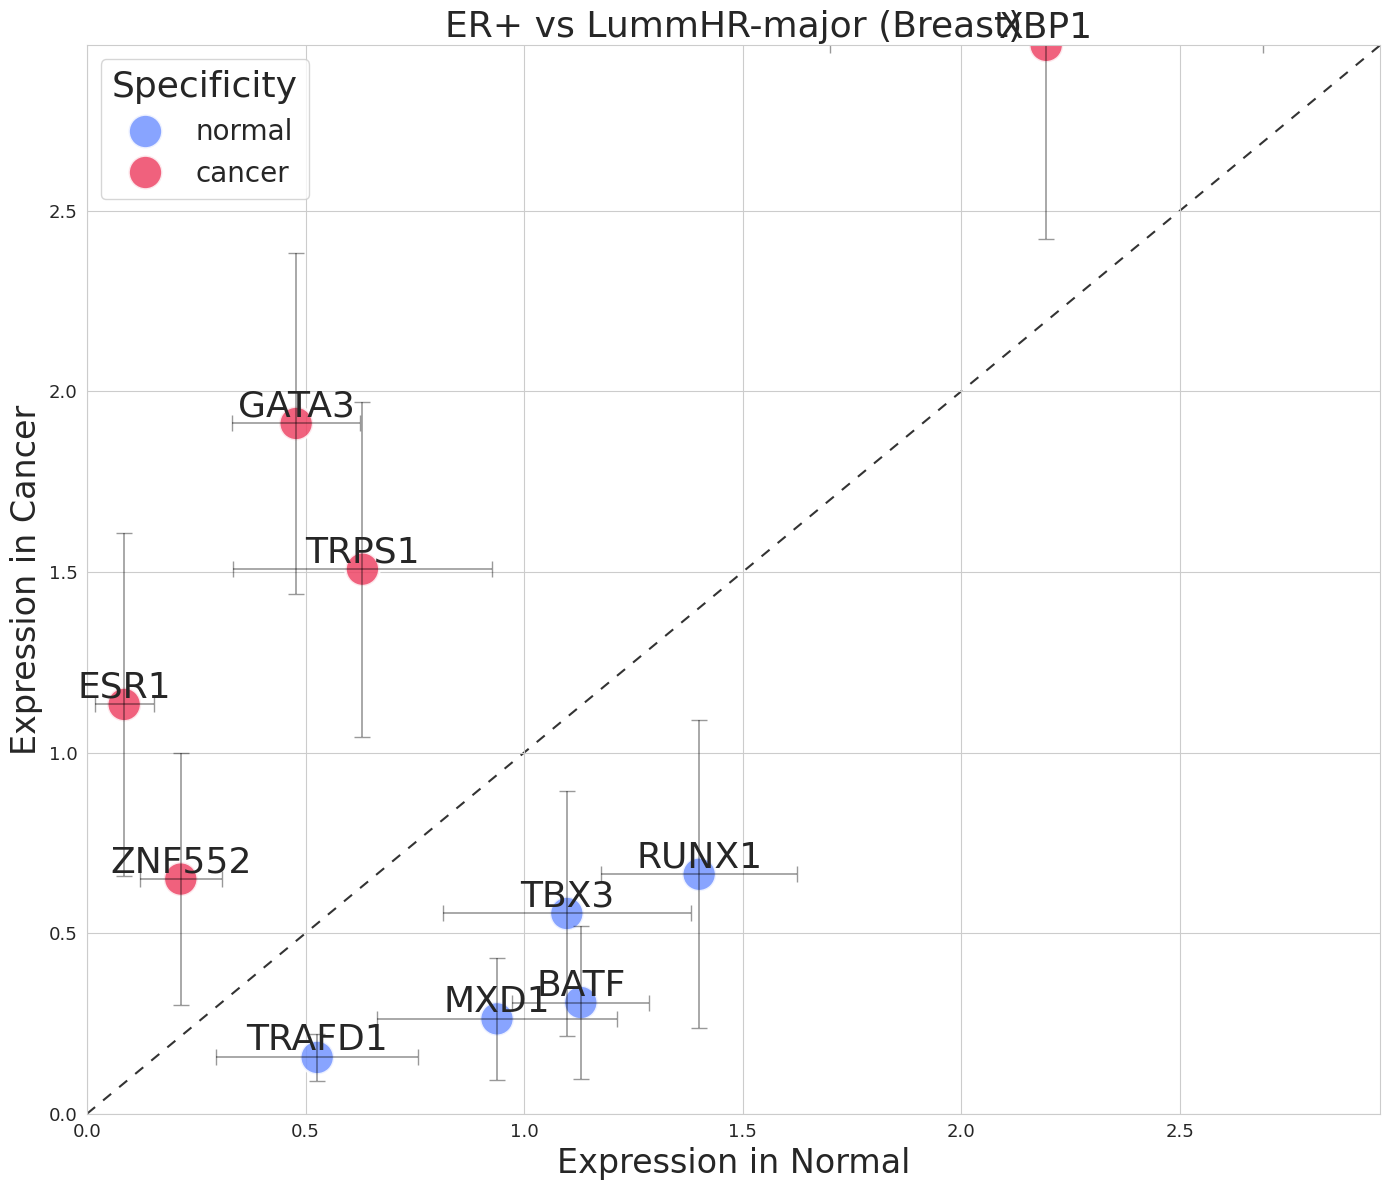

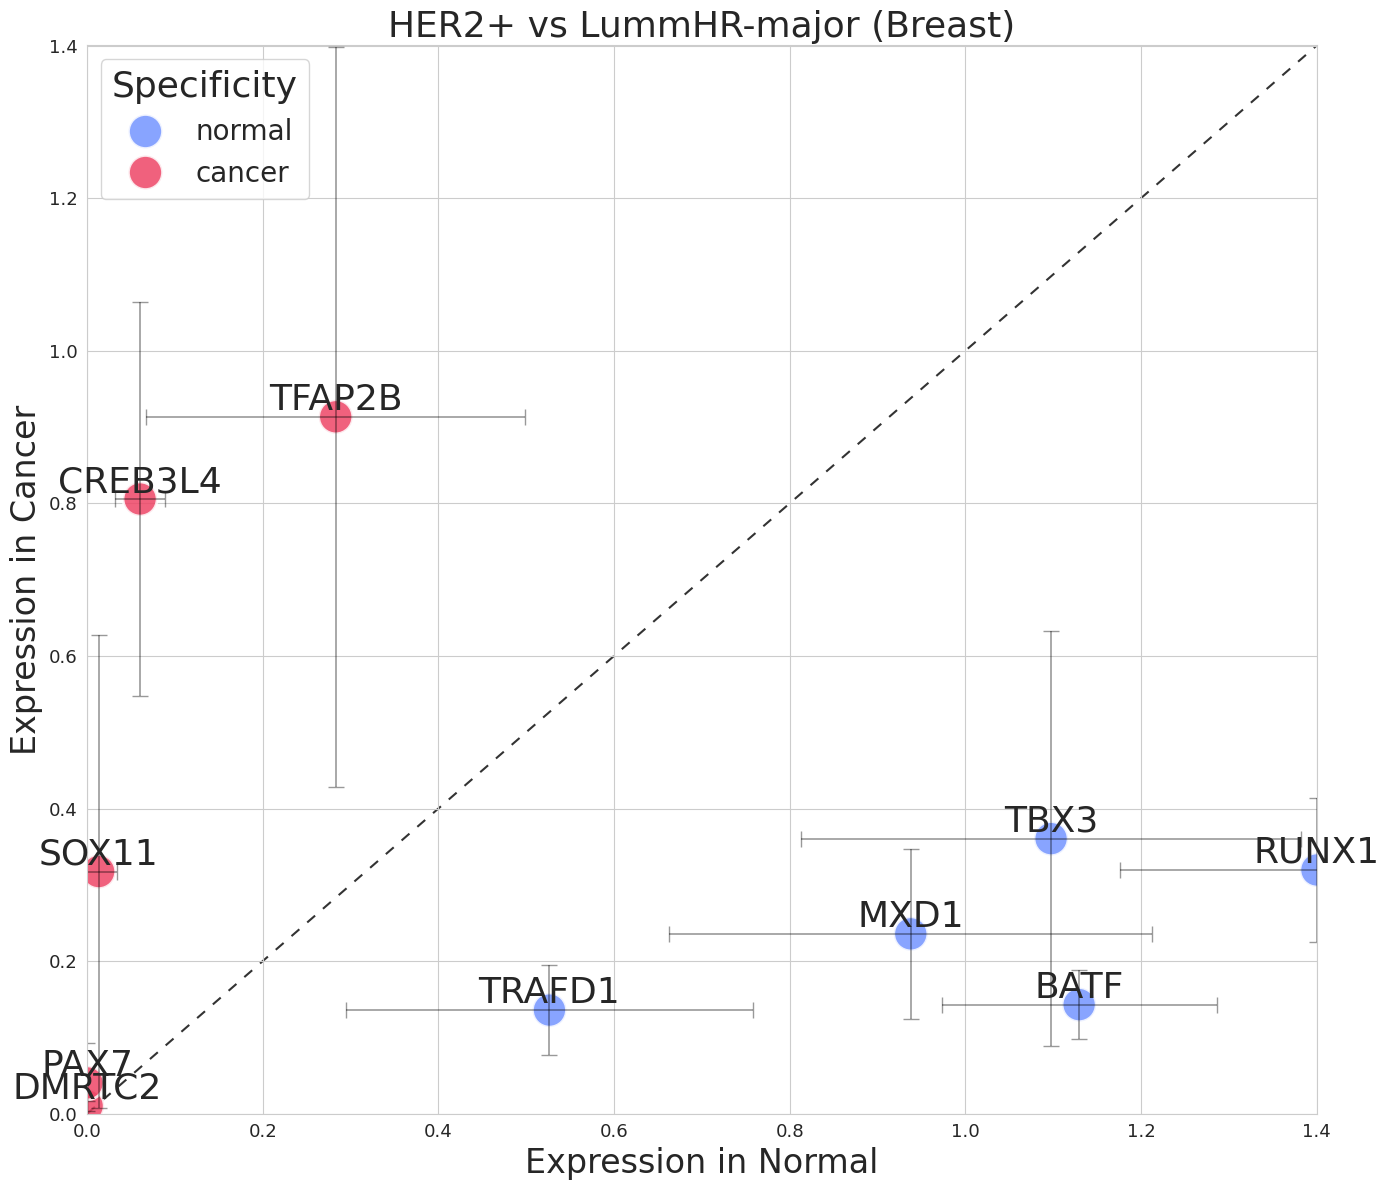

In [ ]:
# View the result
for normal_type, cancer_type in cancer_normal_pairs:
    plot_cancer_vs_normal(
        normal_type,
        cancer_type,
        normal_tfs,
        cancer_tfs,
        normal_pseudobulk,
        cancer_pseudobulk,
    )